# VISTAB

Visualize or tabulate results.

In [4]:
from py_env_hpc import *

## 1. Visualize the IDEA!

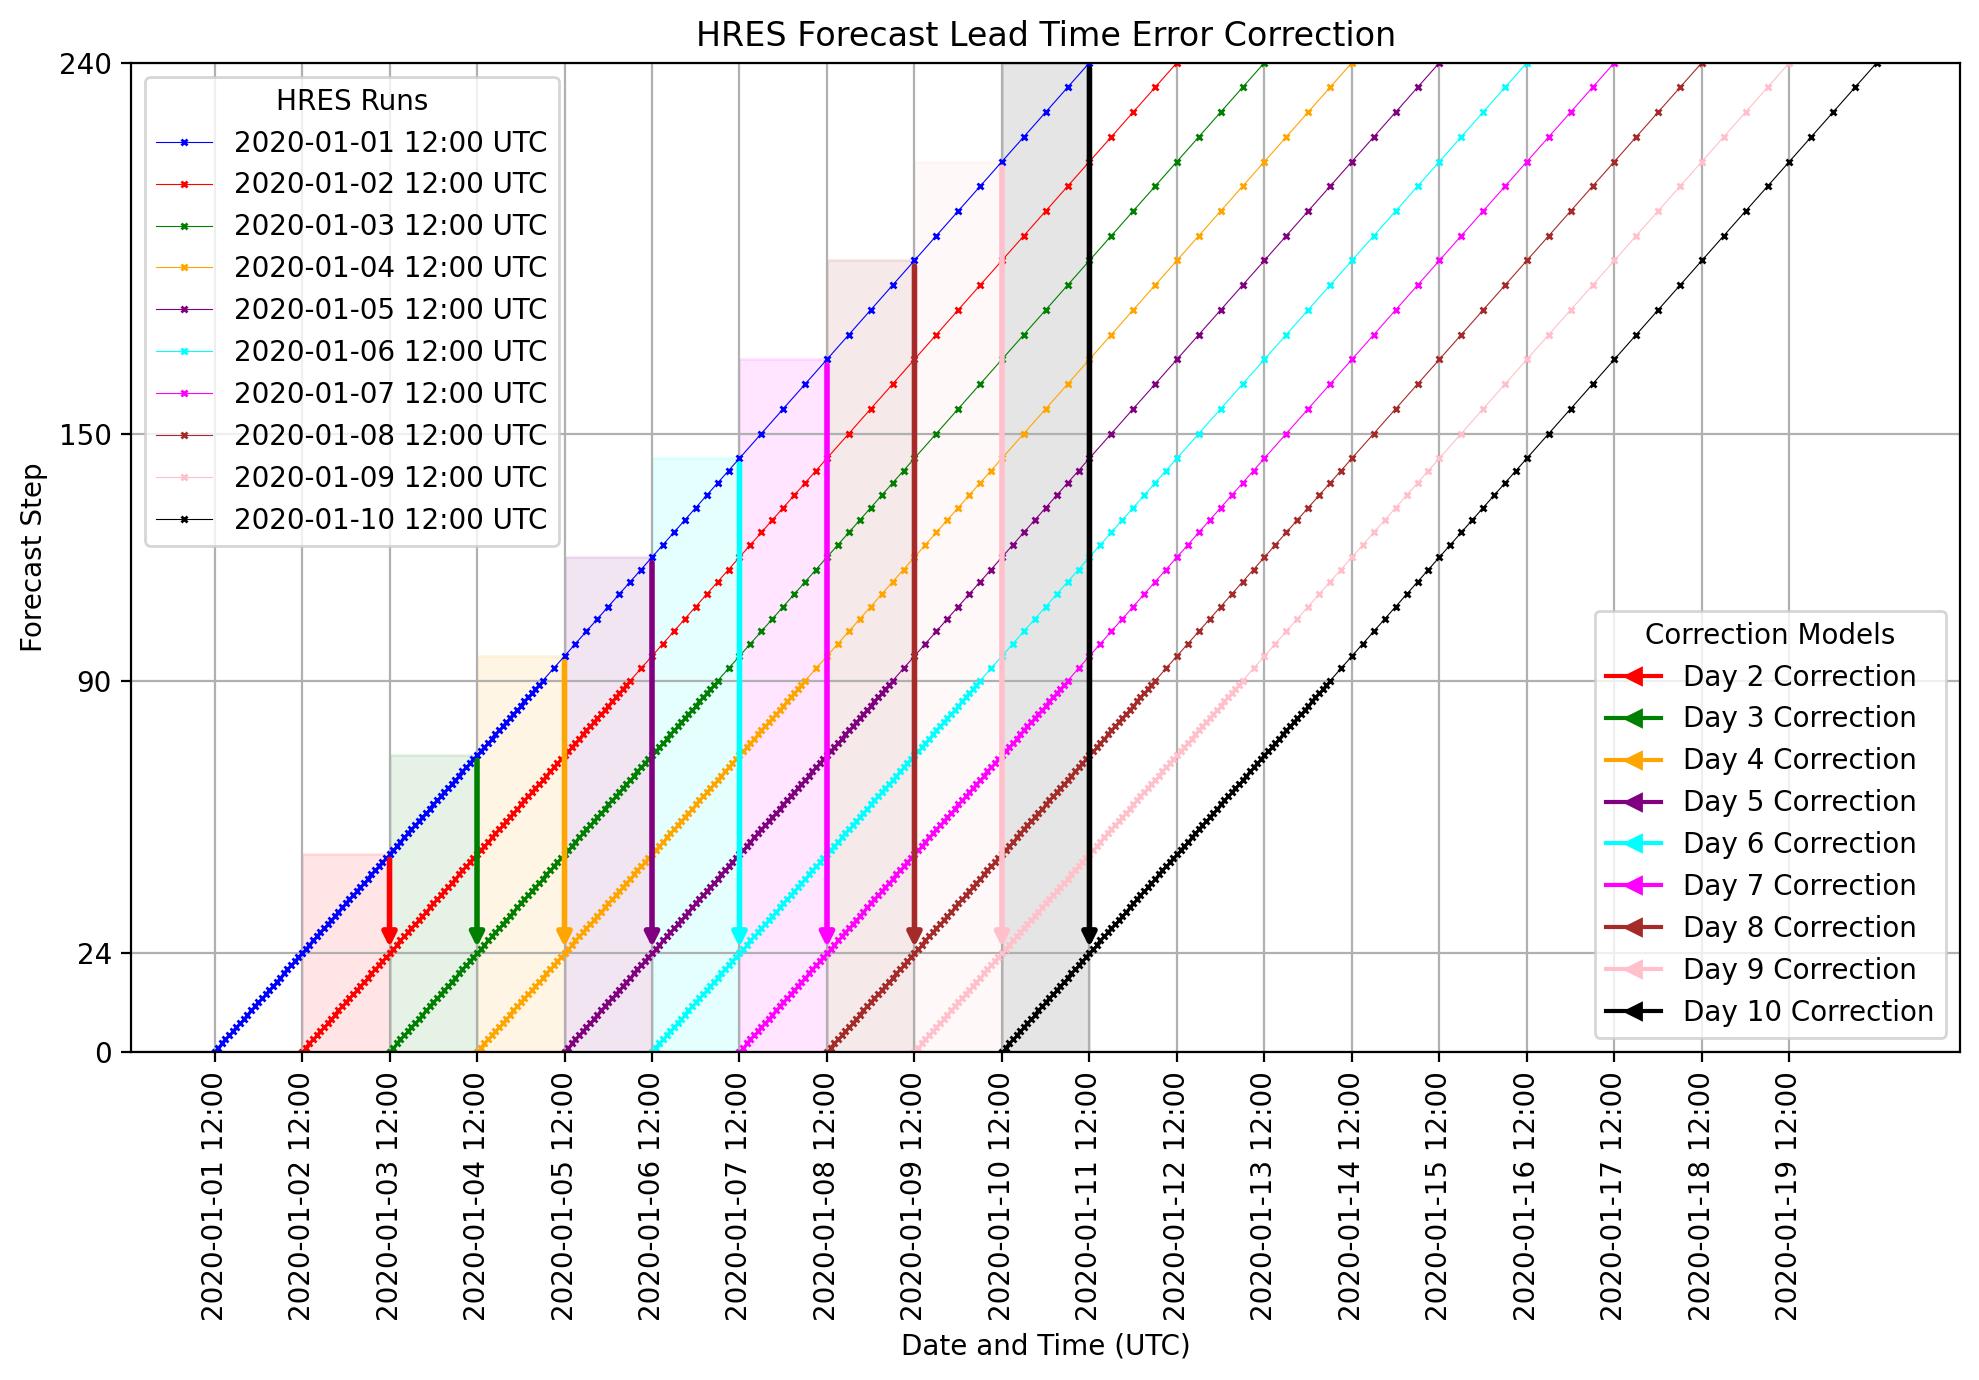

In [2]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
import numpy as np

def generate_forecast_times(start_date, forecast_steps):
    return [start_date + timedelta(hours=step) for step in forecast_steps]

def plot_forecast(run_times, forecast_steps, label, color):
    plt.plot(run_times, forecast_steps, marker='x', linestyle='-', color=color, label=label, ms=2, lw=0.4)

def set_plot_properties(start_date, end_date):
    plt.title('HRES Forecast Lead Time Error Correction')
    plt.xlabel('Date and Time (UTC)')
    plt.ylabel('Forecast Step')

    six_hourly_ticks = [start_date + timedelta(hours=i*24) for i in range(int((end_date - start_date).total_seconds() // 3600 // 24))]
    plt.xticks(six_hourly_ticks, [time.strftime('%Y-%m-%d %H:%M') for time in six_hourly_ticks], rotation=90)
    plt.ylim(0, 240)
    plt.yticks([0, 24, 90, 150, 240])
    plt.legend(title='HRES Runs', loc='upper left')
    plt.grid(True)
    plt.tight_layout()

# Define the starting date and time for each run
start_dates = [
    datetime(year=2020, month=1, day=1, hour=12),
    datetime(year=2020, month=1, day=2, hour=12),
    datetime(year=2020, month=1, day=3, hour=12),
    datetime(year=2020, month=1, day=4, hour=12),
    datetime(year=2020, month=1, day=5, hour=12),
    datetime(year=2020, month=1, day=6, hour=12),
    datetime(year=2020, month=1, day=7, hour=12),
    datetime(year=2020, month=1, day=8, hour=12),
    datetime(year=2020, month=1, day=9, hour=12),
    datetime(year=2020, month=1, day=10, hour=12)
]

# End date and time
end_date = datetime(year=2020, month=1, day=20, hour=12)

# Step frequency for 12 UTC for each run
forecast_steps = [list(range(0, 91)) + list(range(93, 145, 3)) + list(range(150, 241, 6)) for _ in range(10)]

# Calculate the date and time for each forecast step for each run
forecast_times = [generate_forecast_times(start_date, steps) for start_date, steps in zip(start_dates, forecast_steps)]

# Plotting the forecast steps against the corresponding times for each run
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown', 'pink', 'black']
labels = ['2020-01-01 12:00 UTC', '2020-01-02 12:00 UTC', '2020-01-03 12:00 UTC', '2020-01-04 12:00 UTC', '2020-01-05 12:00 UTC', '2020-01-06 12:00 UTC', '2020-01-07 12:00 UTC', '2020-01-08 12:00 UTC', '2020-01-09 12:00 UTC', '2020-01-10 12:00 UTC']

plt.figure(figsize=(10, 7), dpi=200)

for run_times, steps, label, color in zip(forecast_times, forecast_steps, labels, colors):
    plot_forecast(run_times, steps, label, color)

index_24 = 24

# Plot correction models
arrow_handles = []
for c, run_times in enumerate(forecast_times):
    correction_time = run_times[index_24]
    plt.annotate('', xy=(run_times[index_24], 240 + index_24 * (c - 9)), xytext=(run_times[index_24], index_24),
                 arrowprops=dict(arrowstyle='<|-', color=colors[c], linewidth=2),
                 annotation_clip=False)
    arrow_handles.append(Line2D([0], [0], linestyle='-', color=colors[c], marker='<', lw=1.5))
    
    if c >= 1:
        plt.axvspan(correction_time - timedelta(hours=24), correction_time, color=colors[c], alpha=0.1, ymax=(240 + index_24 * (c - 9)) / 240)

correction_labels = ['Day {} Correction'.format(day) for day in np.arange(2, 12)]

# Create a separate legend for correction arrows
arrow_legend = plt.legend(arrow_handles[1:], correction_labels, loc='lower right', title='Correction Models')
plt.gca().add_artist(arrow_legend)

set_plot_properties(start_dates[0], end_date)

# Save figure with white background
plt.savefig(DUMP_PLOT+'/idea.png')
plt.show()


## 1. Training results

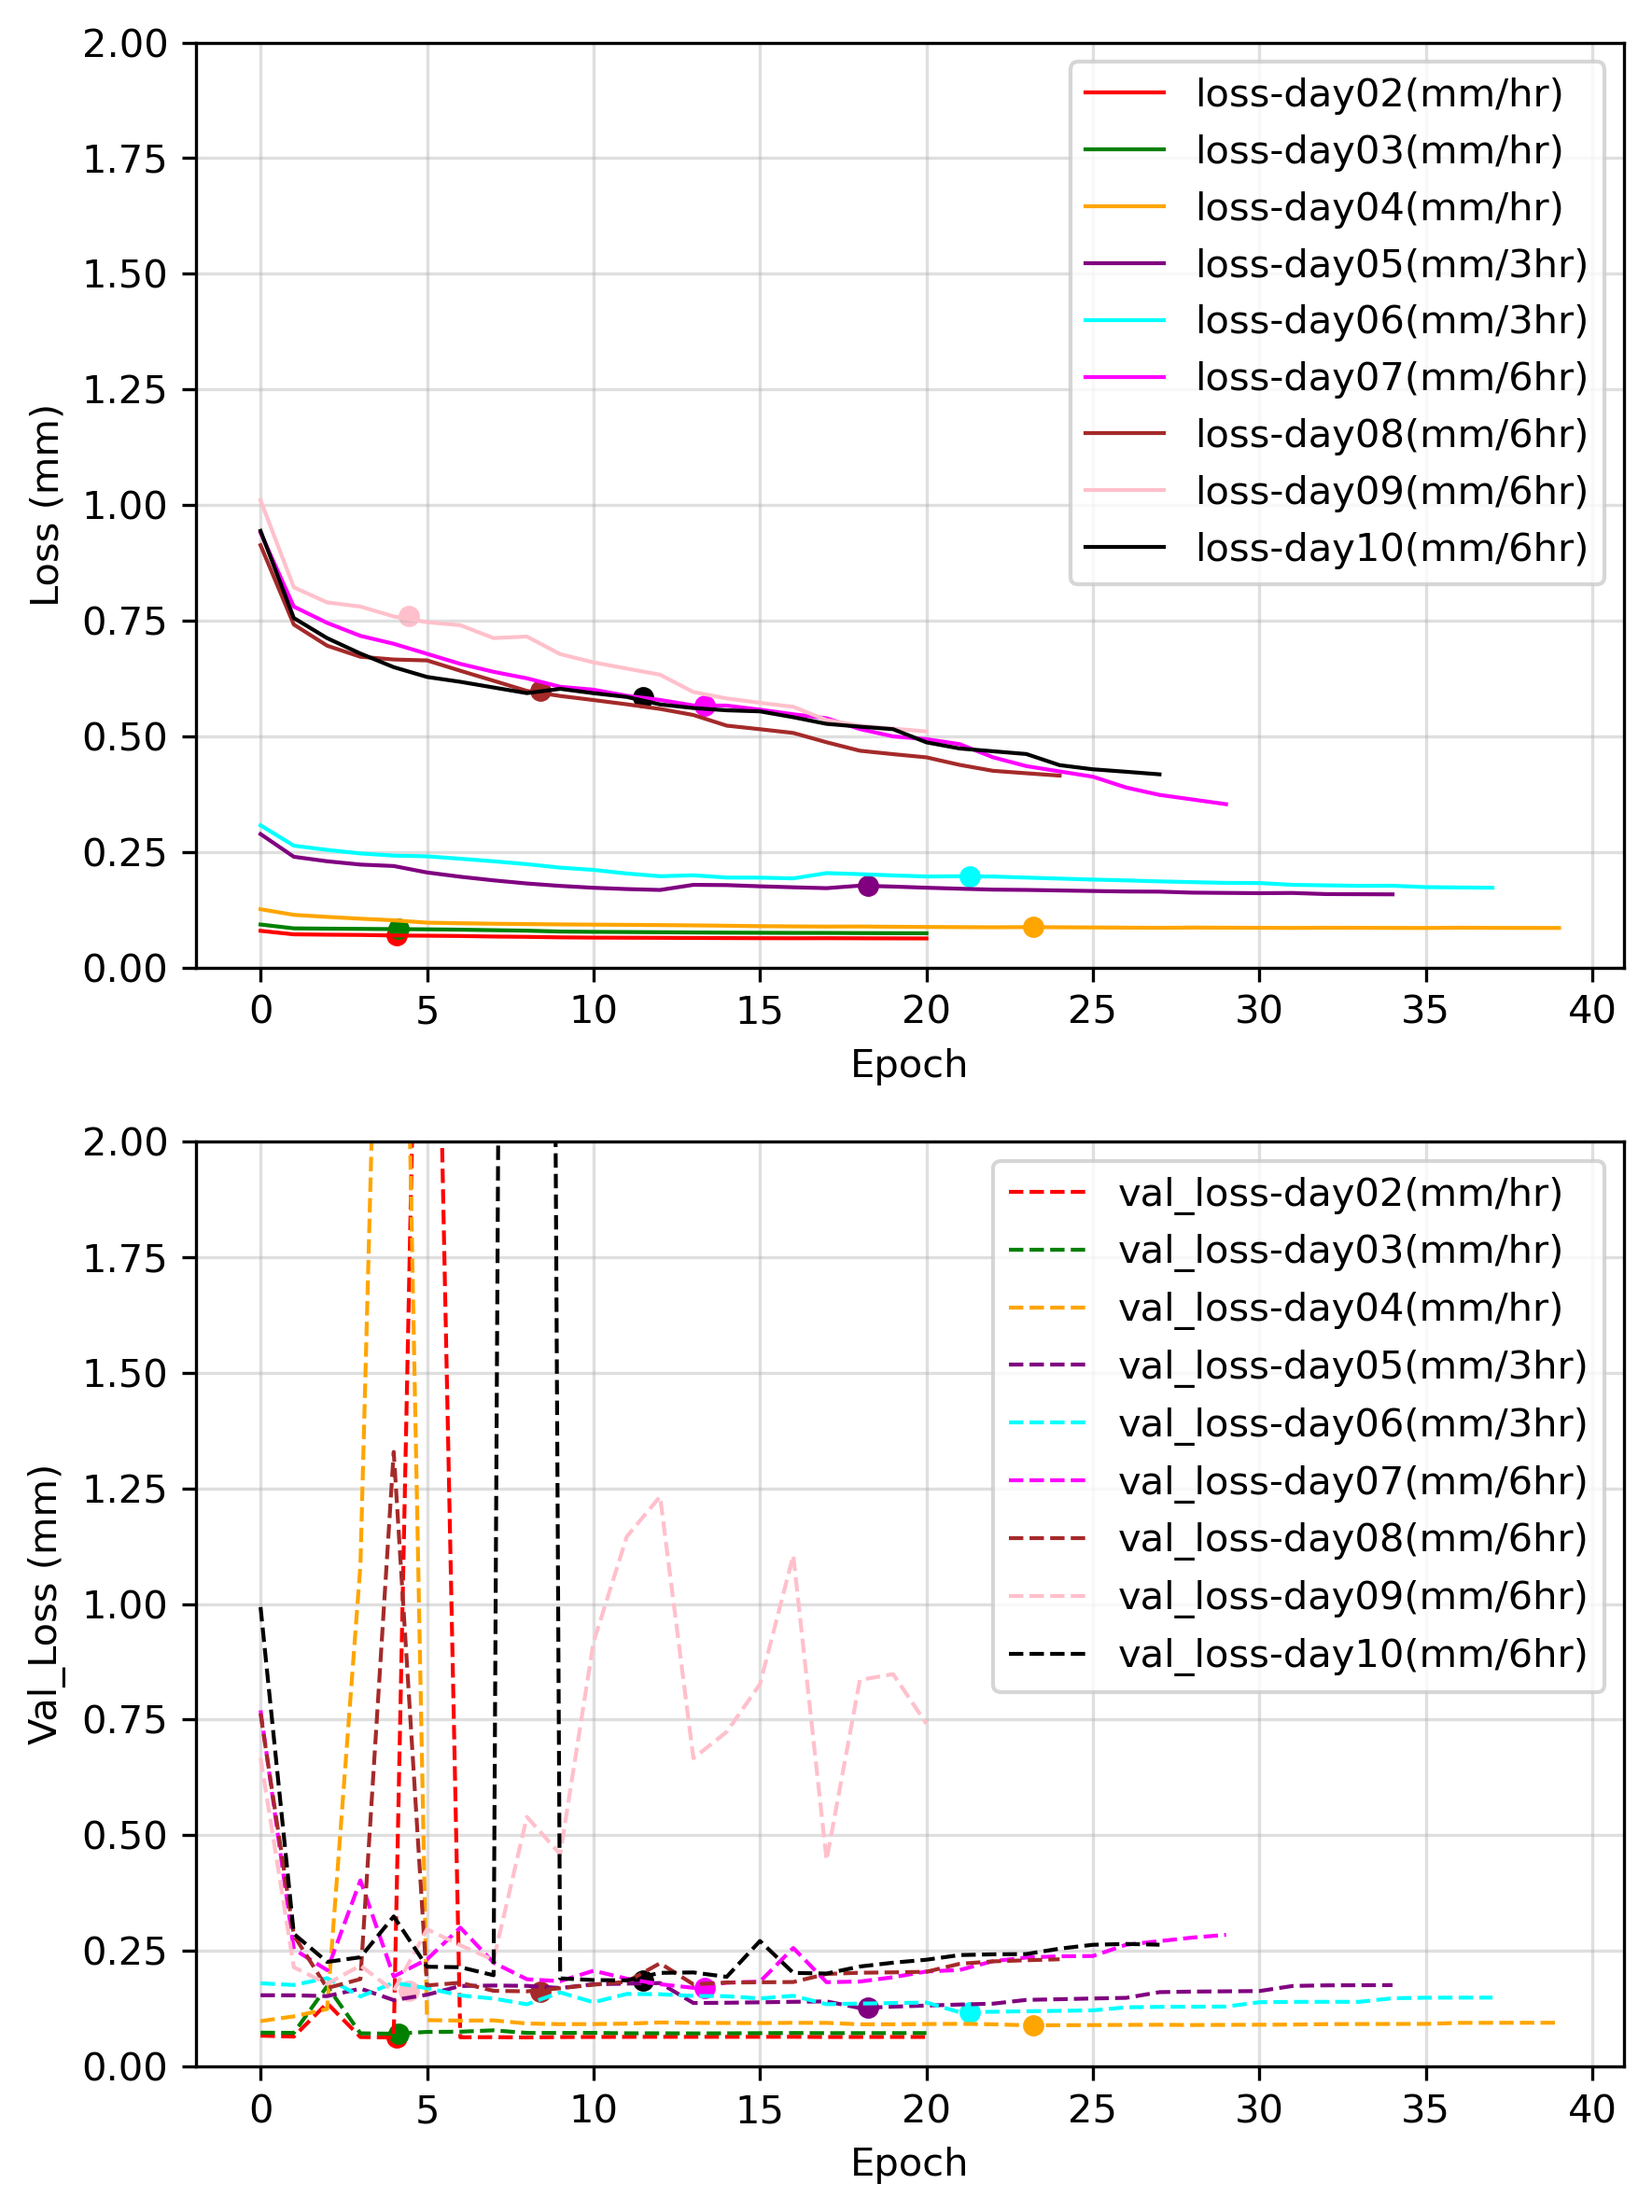

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to directory containing csv files
path_to_csv = PPROJECT_DIR2 + 'HPT/'

# Define colors list
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown', 'pink', 'black']

# Create dictionaries to map days to colors and units
day_colors = {
    '02': colors[1],
    '03': colors[2],
    '04': colors[3],
    '05': colors[4],
    '06': colors[5],
    '07': colors[6],
    '08': colors[7],
    '09': colors[8],
    '10': colors[9]
}

unit_labels = {
    '02': 'mm/hr',
    '03': 'mm/hr',
    '04': 'mm/hr',
    '05': 'mm/3hr',
    '06': 'mm/3hr',
    '07': 'mm/6hr',
    '08': 'mm/6hr',
    '09': 'mm/6hr',
    '10': 'mm/6hr'
}


# Create subplots for loss and val_loss
fig, axs = plt.subplots(2, 1, figsize=(6, 8), dpi=300)

# Iterate over each csv file in the directory
for filename in sorted(os.listdir(path_to_csv)):
    if filename.endswith(".csv"):
        # Extract day from filename
        day = filename[-6:-4]
        # Read csv file
        df = pd.read_csv(os.path.join(path_to_csv, filename))
        # Plot loss
        axs[0].plot(df['loss'], color=day_colors[day], label='loss-day{}({})'.format(day, unit_labels[day]), linewidth=1)
        # Plot val_loss
        axs[1].plot(df['val_loss'], linestyle='--', color=day_colors[day], label='val_loss-day{}({})'.format(day, unit_labels[day]), linewidth=1)
        # Find index of minimum val_loss for the day
        min_val_loss_index = df['val_loss'].idxmin()
        # Plot point at the minimum val_loss index
        axs[1].scatter(min_val_loss_index+0.05*int(day), df['val_loss'][min_val_loss_index], color=day_colors[day], marker='o', s=20)
        axs[0].scatter(min_val_loss_index+0.05*int(day), df['loss'][min_val_loss_index], color=day_colors[day], marker='o', s=20)

# Add grids to both subplots
axs[0].grid(True, alpha=0.4)
axs[1].grid(True, alpha=0.4)

axs[0].set_ylim(0, 2)
axs[1].set_ylim(0, 2)

# Add labels and legends to the subplots
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss (mm)')
axs[0].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Val_Loss (mm)')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Save figure with white background
plt.savefig(DUMP_PLOT+'/training_results.png', bbox_inches='tight', dpi=300, facecolor='white')
plt.show()


## 2. Forecast error correction results

In [4]:
# Define the error metrics, temporal resolutions, and seasons
from matplotlib.colors import LinearSegmentedColormap

# Define the plot ranges, units, and colormaps for each error metric and temporal resolution
plot_ranges = {
    ("ME", "hourly"): (-0.4, 0.4),
    ("ME", "daily"): (-4, 4),
    ("ME", "monthly"): (-100, 100),
    ("RMSE", "hourly"): (0, 2),
    ("RMSE", "daily"): (0, 6),
    ("RMSE", "monthly"): (0, 100),
    ("COR", "hourly"): (0, 1),
    ("COR", "daily"): (0, 1),
    ("COR", "monthly"): (0, 1),
}

units = {
    ("ME", "hourly"): "mm/hr",
    ("ME", "daily"): "mm/day",
    ("ME", "monthly"): "mm/month",
    ("RMSE", "hourly"): "mm/hr",
    ("RMSE", "daily"): "mm/day",
    ("RMSE", "monthly"): "mm/month",
    ("COR", "hourly"): "Hourly",
    ("COR", "daily"): "Daily",
    ("COR", "monthly"): "Monthly",
}

colormaps = {
    ("ME", "hourly"): plt.get_cmap("coolwarm", 8),
    ("ME", "daily"): plt.get_cmap("coolwarm", 8),
    ("ME", "monthly"): plt.get_cmap("coolwarm", 10),
    ("RMSE", "hourly"): plt.get_cmap("rainbow", 10),
    ("RMSE", "daily"): plt.get_cmap("rainbow", 12),
    ("RMSE", "monthly"): plt.get_cmap("rainbow", 10),
    ("COR", "hourly"): plt.get_cmap("rainbow", 10),
    ("COR", "daily"): plt.get_cmap("rainbow", 10),
    ("COR", "monthly"): plt.get_cmap("rainbow", 10),
}


# Define the plot ranges, units, and colormaps for each error metric and temporal resolution for improvement plots

plot_ranges_i = {
    ("ME", "hourly"): (-20, 20),
    ("ME", "daily"): (-20, 20),
    ("ME", "monthly"): (-20, 20),
    ("RMSE", "hourly"): (-20, 20),
    ("RMSE", "daily"): (-20, 20),
    ("RMSE", "monthly"): (-20, 20),
    ("COR", "hourly"): (-20, 20),
    ("COR", "daily"): (-20, 20),
    ("COR", "monthly"): (-20, 20),
}

units_i = {
    ("ME", "hourly"): "Improvement (%)",
    ("ME", "daily"): "Improvement (%)",
    ("ME", "monthly"): "Improvement (%)",
    ("RMSE", "hourly"): "Improvement (%)",
    ("RMSE", "daily"): "Improvement (%)",
    ("RMSE", "monthly"): "Improvement (%)",
    ("COR", "hourly"): "Improvement (%)",
    ("COR", "daily"): "Improvement (%)",
    ("COR", "monthly"): "Improvement (%)",
}

RGmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=8) 

In [ ]:
import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec

# Figure settings
fs = 1  # Scale for resizing the figure

lead_times = [f"{day:02d}" for day in range(2, 11)]
metric_labels = ['Mean Error', 'Root Mean Squared Error', 'Correlation Coefficient']
metrics_short = ['ME', 'RMSE', 'COR']
product_labels = ['HRES', 'HRES_C']
temporal_resolution = "daily"

# Define figure and axes using GridSpec
fig = plt.figure(figsize=(16 * fs, 18 * fs), dpi=300)
gs = gridspec.GridSpec(len(lead_times), len(metric_labels) * len(product_labels) + 1, width_ratios=[1] * (len(metric_labels) * len(product_labels)) + [0.05])

for i, lead_time in enumerate(lead_times):
    for j, product in enumerate(product_labels):
        for mm in range(3):  # Metrics
            metric_short = metrics_short[mm]
            metric = metric_labels[mm]
            
            # Read the data
            file_path = STATS + "/ADAPTER_DE05.day" + lead_time + "_" + product + "_stats.nc"
            if os.path.exists(file_path):
                data = xr.open_dataset(file_path)
                metric_data = data[metric].values
            else:
                print(file_path + " does not exist!")
            
            # Plot the data as map
            latitudes = data["latitude"].values
            longitudes = data["longitude"].values
            plot_range = plot_ranges[(metrics_short[mm], temporal_resolution)]
            unit = units[(metrics_short[mm], temporal_resolution)]
            cmap = colormaps[(metrics_short[mm], temporal_resolution)]
            
            ax = plt.subplot(gs[i, j * len(metric_labels) + mm], projection=ccrs.PlateCarree())
            
            ax.coastlines(resolution='auto', linestyle='-', alpha=0.5)  # Increase border line detail
            ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)  # Increase country border line detail
            im = ax.pcolormesh(longitudes, latitudes, metric_data, cmap=cmap, vmin=plot_range[0], vmax=plot_range[1], transform=ccrs.PlateCarree())
            
            if i == len(lead_times) - 1:  # Check if it's the last day
                # Add colorbar for the last day (day 10) to each ax individually
                cbar = plt.colorbar(im, ax=ax, orientation='horizontal', aspect=30, pad=0.05)
                cbar.set_label(f'{metric_short}({unit})')
            
            if i == 0:
                ax.set_title(f'{product}')
                
            if product == 'HRES' and metric_short == 'ME':
                ax.text(-0.15, 0.5, f'Day {lead_time}', rotation=90, va='center', ha='center', transform=ax.transAxes)            
            data.close()

# Show plot
plt.show()
plt.savefig(DUMP_PLOT+'/errors.png', dpi=300, facecolor='white')
plt.show()

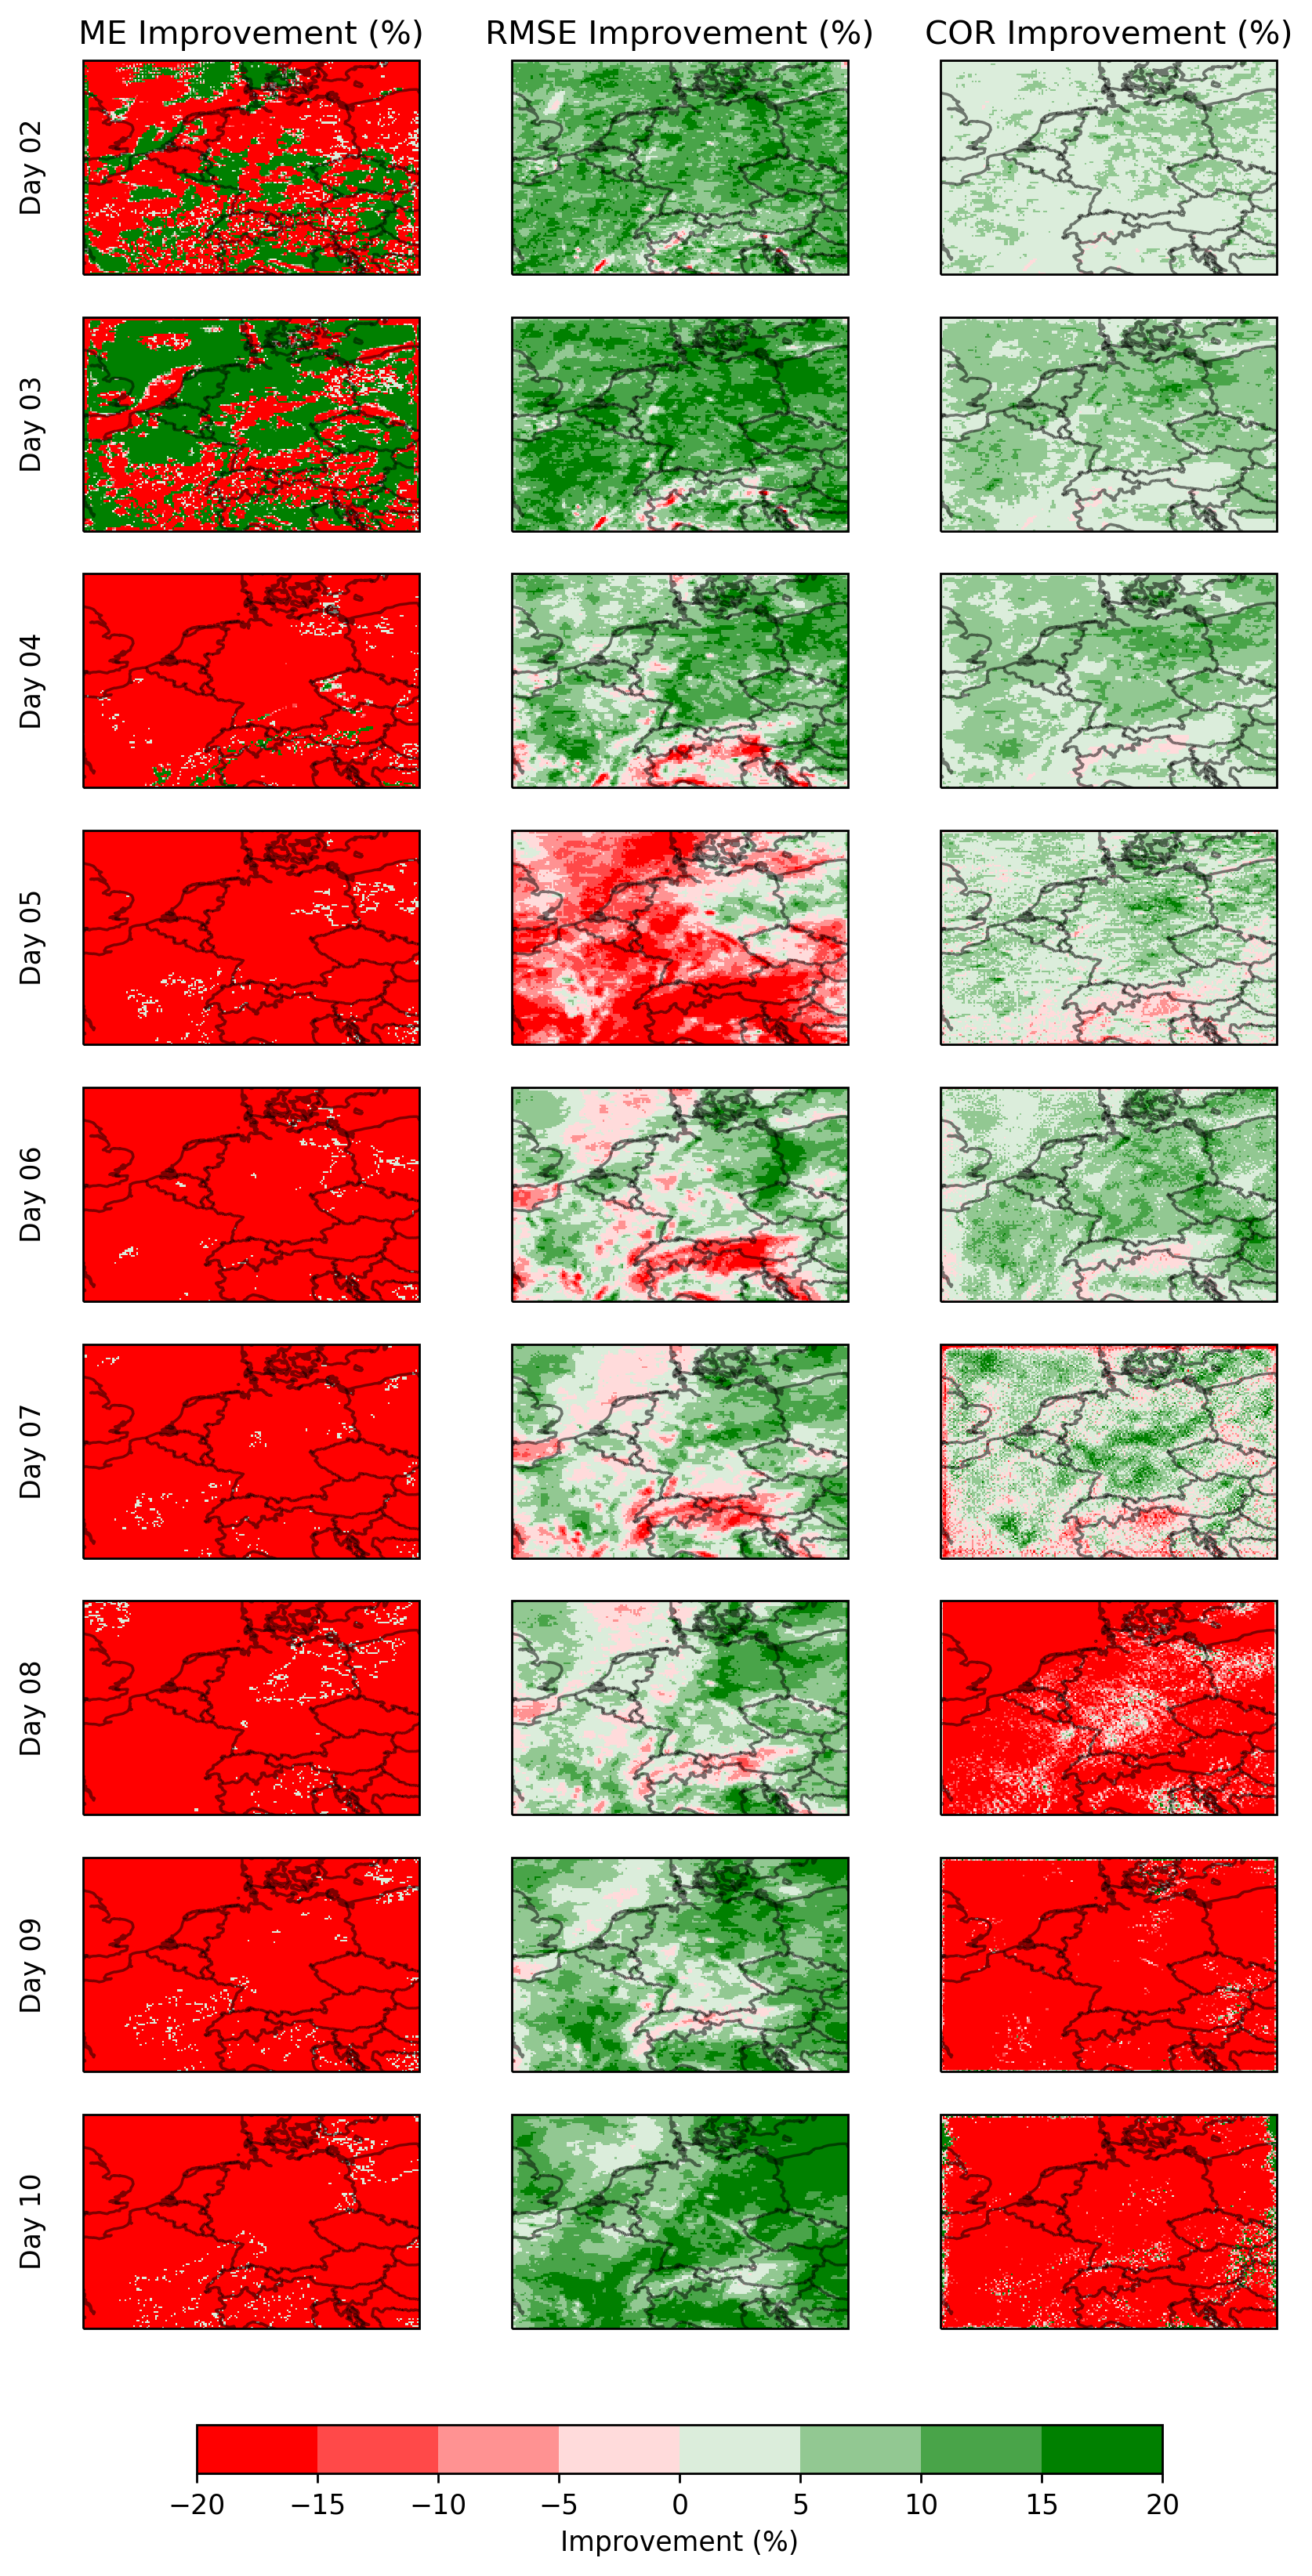

In [36]:
import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np

#figure settings:
fs=1 #scale for resizing the figure

lead_times = [f"{day:02d}" for day in range(2, 11)]
metric_labels = ['Mean Error', 'Root Mean Squared Error', 'Correlation Coefficient']
metrics_short = ['ME', 'RMSE', 'COR']
product_labels = ['HRES', 'HRES_C']
temporal_resolution = "daily"

# Define figure and axes
fig, axs = plt.subplots(len(lead_times), len(metric_labels), figsize=(8 * fs, 16 * fs), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=250)

for i, lead_time in enumerate(lead_times):
    for mm in range(3):  # Metrics
        metric_short = metrics_short[mm]
        metric = metric_labels[mm]
        
        # File paths for HRES and HRES-C
        file_path_hres = f"{STATS}/ADAPTER_DE05.day{lead_time}_HRES_stats.nc"
        file_path_hres_c = f"{STATS}/ADAPTER_DE05.day{lead_time}_HRES_C_stats.nc"
        
        if os.path.exists(file_path_hres) and os.path.exists(file_path_hres_c):
            data_hres = xr.open_dataset(file_path_hres)
            data_hres_c = xr.open_dataset(file_path_hres_c)
            
            metric_data_hres = data_hres[metric].values
            metric_data_hres_c = data_hres_c[metric].values
            
            if metric_short in ['ME', 'RMSE']:
                # Calculate percentage reduction
                mask = np.abs(metric_data_hres) >= 0.01
                improvement = np.zeros_like(metric_data_hres)
                improvement[mask] = 100 * (np.abs(metric_data_hres[mask]) - np.abs(metric_data_hres_c[mask])) / np.abs(metric_data_hres[mask])
            else:  # COR
                # Calculate percentage improvement
                improvement = 100 * (metric_data_hres_c - metric_data_hres) / np.abs(metric_data_hres)
            
            latitudes = data_hres["latitude"].values
            longitudes = data_hres["longitude"].values
            plot_range = plot_ranges_i[(metric_short, "daily")]
            cmap = RGmap
            
            ax = axs[i, mm]
            ax.coastlines(resolution='auto', linestyle='-', alpha=0.5)
            ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
            im = ax.pcolormesh(longitudes, latitudes, improvement, cmap=cmap, vmin=plot_range[0], vmax=plot_range[1], transform=ccrs.PlateCarree())
            
            if i == 0:
                ax.set_title(f'{metric_short} Improvement (%)')
                
                            
            if metric_short == 'ME':
                ax.text(-0.15, 0.5, f'Day {lead_time}', rotation=90, va='center', ha='center', transform=ax.transAxes)            
            data.close()
                
            data_hres.close()
            data_hres_c.close()
        else:
            print(f"Files for lead time {lead_time} do not exist!")

# Add colorbar
cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
cbar.set_label('Improvement (%)')

# Show plot
plt.show()

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
lead_time = "03"
start_date = '2018-01-01'
end_date = '2023-12-31'

file_path_hres = f"{HRES_PREP}/ADAPTER_DE05.day{lead_time}.merged.nc"
file_path_hres_c = f"{PREDICT_FILES}/ADAPTER_DE05.day{lead_time}.merged.nc.corrected.nc"
file_path_ref = f"{HRES_PREP}/ADAPTER_DE05.day01.merged.nc"

data_hres = xr.open_dataset(file_path_hres)
data_hres_c = xr.open_dataset(file_path_hres_c)
data_ref = xr.open_dataset(file_path_ref)

# Select data for the year 2018
data_hres = data_hres.sel(time=slice(start_date, end_date))
data_hres_c = data_hres_c.sel(time=slice(start_date, end_date))
data_ref = data_ref.sel(time=slice(start_date, end_date))

# Align datasets according to reference
data_hres, data_hres_c, data_ref = xr.align(data_hres, data_hres_c, data_ref, join='inner')

# Resample datasets to daily frequency
data_hres_daily = data_hres.resample(time='1M').sum()
data_hres_c_daily = data_hres_c.resample(time='1M').sum()
data_ref_daily = data_ref.resample(time='1M').sum()

# Select a random point
np.random.seed(2)  # For reproducibility
latitudes = data_hres_daily.latitude.values
longitudes = data_hres_daily.longitude.values
random_lat = np.random.choice(latitudes)
random_lon = np.random.choice(longitudes)

# Extract time series data for the chosen point
time_series_hres = data_hres_daily.sel(latitude=random_lat, longitude=random_lon, method="nearest")
time_series_hres_c = data_hres_c_daily.sel(latitude=random_lat, longitude=random_lon, method="nearest")
time_series_ref = data_ref_daily.sel(latitude=random_lat, longitude=random_lon, method="nearest")

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series_hres.time, time_series_hres.pr, label='HRES')
plt.plot(time_series_hres_c.time, time_series_hres_c.pr, label='HRES_C')
plt.plot(time_series_ref.time, time_series_ref.pr, label='Reference')

plt.title(f'Time Series at (lat: {np.round(random_lat, 2)}, lon: {np.round(random_lon, 2)})')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Close datasets
data_hres.close()
data_hres_c.close()
data_ref.close()